# Significant aspects of model construction

* econ status
* ~bubbles~
* spatiality
* mobility

Metrics upon which to assess these:
* cases over time
* deaths over time
* effective R at different points
* constraint-specific measures (e.g. cases over time per district in models with districts)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pylab as plt
from os.path import isfile, join
from glob import glob
import subprocess
import re


import seaborn as sns
sns.set(style="darkgrid")

In [2]:
def processModelOutput(filename):
    r_data = pd.read_csv(filename, sep='\t')
    r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]]
    return {'results': r_data}

def findROFInstance():
    # total number of individuals infected by the introduction of an infectious person
    return beta * n

def WorldBankMASONmodel(seed, paramfile, beta):
    
    dataDir = "/home/wb488473/Disease-Modelling-SSA/data/"
    numDays = 30 * 6
    
    exportFilename = "exportDailyMetrics_" + seed + "_" + beta + ".txt"
    exportInfectionsFilename = "exportInfections_" + seed + "_" + beta + ".txt"
    
    subprocess.call(['java', '-Xms20G', '-jar', '../java/WorldBankCovid19/libs/WB_covid19ABM.jar', str(numDays), 
                     dataDir, str(beta), seed, exportFilename, paramfile, exportInfectionsFilename])
    
    # Sophie upped the -Xms to 20G from 6GB
    return processModelOutput(exportFilename)

In [11]:
pwd

'/home/wb488473/Disease-Modelling-SSA/notebooks'

## Undifferentiated base case

Individuals are created without distinct statuses and their interaction is perfect mixing with the entire community. There is a single district in which each agent is initialised and movement between districts (being meaningless) is zeroed out. Thus, status, social groups, and space are all excluded from this scenario.

The data directory associated with this case is inunder the directory **data/verification/** and the specific set of parameters is as given in the file **data/verification/params_default1Dist.txt**. In particular:

* the census file has all economic statuses set to the value "Default" and all locations for home and work set to an imaginary "District 1"
* the daily transitions files are both set to 100% chance of moving from District 1 to District 1.
* mobility rates do not decrease after a lockdown...
* the lockdown file is empty of scheduled lockdowns, however, for belt-and-bracers insurance!

The infection parameters are the defaults as seen in the config/covasim_infect_transitions.txt

The data to vary are therefore the following:
* **numWeeklyInteractionsByStatus_default.txt**: a record of how many interactions agents with the "Default" status should have per week
* **lineList_5Perc_singleDist.txt**: the infections to seed in the single district.

An exploration of these is given below.

* initialise with 20 cases
* comparison: .03 and .3 betas
* population sizes: 10% versus this 5%

Running the scenarios.

(WANT MORE SCENARIOS?? Just add more hateful loops! Or change betas to pop size, etc! Add new param files! Go hog wild!!!)

In [13]:
paramsPerScenario = ["../data/verification/params_default1Dist"]   
betasPerScenario = [0.03, 0.3]

for paramsFile in paramsPerScenario:
    for myBeta in betasPerScenario:
        for i in range(10):
            WorldBankMASONmodel("sweep_default1Dist_betaComparison_", i, paramsFile, myBeta)

TypeError: can only concatenate str (not "float") to str

#### Cases over time


In [14]:
def plotMetric(files, prefix, suffix, metrics = [], symbol = "-", alpha=1, weighting = 1):
    myAvgLine = []
    index = 0
    template = "^" + prefix + ".*" + suffix + "$"

    for f in files:

        if(re.search(template, f) != None): # f.startswith(prefix) and 
            r_data = pd.read_csv(path + f, sep='\t')
            totcases = []
            for metric in metrics:
                if len(totcases) == 0:
                    totcases = r_data[metric]
                else:        
                    totcases = totcases + r_data[metric]
            #totcases = r_data[metric]
            
            if len(myAvgLine) == 0:
                myAvgLine = totcases
            else:
                myAvgLine += totcases
            
            # plot it
            plt.plot(r_data["time"][1:], weighting * totcases[1:], symbol, alpha=alpha)
            index += 1
    return {"myLine": weighting * myAvgLine/index, "myTime": r_data["time"]}

## HERE BE CODE FORMERLY USED FOR BUBBLES - CANNABALISE ACCORDINGLY

In [16]:
path = "/home/wb488473/Disease-Modelling-SSA/data/verification/output"
files = os.listdir(path)

prefix = "exportBubblesOf30_"
prefix2 = "exportBubbles_20perc"

line1 = plotMetric(files, prefix, "0.016.txt", ["metric_new_cases_sympt", "metric_new_cases_asympt"],
                   'r-', 0.15, weighting=4)
#line2 = plotMetric(files, prefix2, "0.016.txt", "metric_new_cases_sympt", 'b-', 0.15)
#line4 = plotMetric(files, prefix, "0.05.txt", "metric_new_cases_sympt", 'y-', 0.15)
#line3 = plotMetric(files, prefix, "0.1.txt", "metric_new_cases_sympt", 'g-', 0.15)
#line5 = plotMetric(files, prefix2, "0.1.txt", "metric_new_cases_sympt", 'g', 0.15)
#line6 = plotMetric(files, prefix2, "0.05.txt", "metric_new_cases_sympt", 'y', 0.15)

plt.plot(line1["myTime"][1:], 4* line1['myLine'][1:], 'r', label="Bubbles - 5% - .016 Beta")
#plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="Bubbles - 20% - .016 Beta")
#plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="Perfect Mixing - .03 Beta")
#plt.plot(line4["myTime"][1:], line4['myLine'][1:], 'y', label="Perfect Mixing - .05 Beta")
#plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'g', label="Perfect Mixing - .10 Beta")
plt.legend()

#plt.savefig(path + "comparisonOfCases.png", dpi=300)

TypeError: unsupported operand type(s) for /: 'list' and 'int'

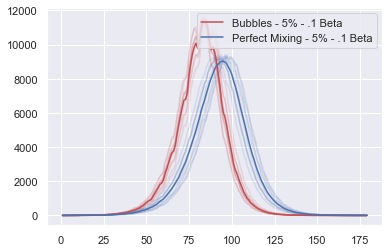

In [84]:
path = "/home/wb488473/Disease-Modelling-SSA/data/verification/output"
files = os.listdir(path)

prefix = "exportBubblesOf30_"
prefix2 = "exportPerfect"

line1 = plotMetric(files, prefix, "0.1.txt", "metric_new_cases_sympt", 'r-', 0.15)
line2 = plotMetric(files, prefix2, "0.1.txt", "metric_new_cases_sympt", 'b-', 0.15)
#line4 = plotMetric(files, prefix, "0.05.txt", "metric_new_cases_sympt", 'y-', 0.15)
#line3 = plotMetric(files, prefix, "0.1.txt", "metric_new_cases_sympt", 'g-', 0.15)
#line5 = plotMetric(files, prefix2, "0.1.txt", "metric_new_cases_sympt", 'g', 0.15)
#line6 = plotMetric(files, prefix2, "0.05.txt", "metric_new_cases_sympt", 'y', 0.15)

plt.plot(line1["myTime"][1:], line1['myLine'][1:], 'r', label="Bubbles - 5% - .1 Beta")
plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="Perfect Mixing - 5% - .1 Beta")
#plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="Perfect Mixing - .03 Beta")
#plt.plot(line4["myTime"][1:], line4['myLine'][1:], 'y', label="Perfect Mixing - .05 Beta")
#plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'g', label="Perfect Mixing - .10 Beta")
plt.legend()

plt.savefig(path + "bubblesVersusNo_5_1.png", dpi=300)

In [30]:
#line3 = plotMetric(files, "exportPerfect", "0.3.txt", "metric_new_cases_sympt", 'b-', 0.15)
#plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'r', label="Perfect Mixing - .30 Beta")


<Figure size 432x288 with 0 Axes>

Direct comparison of spikiness in bubble version

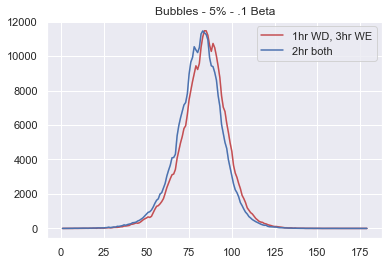

In [94]:
path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/output/"
files = os.listdir(path)

prefix = "exportBubblesOf30_0_"
prefix2 = "testing_30bubbles_weekdayWeekendSame_"

line1 = plotMetric(files, prefix, "0.1.txt", "metric_new_cases_sympt", 'r-', 0.15)
line2 = plotMetric(files, prefix2, "0.1.txt", "metric_new_cases_sympt", 'b-', 0.15)
#line4 = plotMetric(files, prefix, "0.05.txt", "metric_new_cases_sympt", 'y-', 0.15)
#line3 = plotMetric(files, prefix, "0.1.txt", "metric_new_cases_sympt", 'g-', 0.15)
#line5 = plotMetric(files, prefix2, "0.1.txt", "metric_new_cases_sympt", 'g', 0.15)
#line6 = plotMetric(files, prefix2, "0.05.txt", "metric_new_cases_sympt", 'y', 0.15)

plt.plot(line1["myTime"][1:], line1['myLine'][1:], 'r', label="1hr WD, 3hr WE")
plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="2hr both")
#plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="Perfect Mixing - .03 Beta")
#plt.plot(line4["myTime"][1:], line4['myLine'][1:], 'y', label="Perfect Mixing - .05 Beta")
#plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'g', label="Perfect Mixing - .10 Beta")
plt.title("Bubbles - 5% - .1 Beta")
plt.legend()

plt.savefig(path + "leisureTimeComparison.png", dpi=300)

Calculating the r_eff

In [98]:
path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/notebooks/"
filename = "infections_0.016_4_180_4.txt"
r_data = pd.read_csv(path + filename, sep='\t')


In [174]:
infections = r_data[r_data["ContagiousAt"] != '1.7976931348623157E308']
infections["HostNew"] = infections["Host"].astype(float).astype(str)
infections["SourceNew"] = infections["Source"].astype(str)
infections


<ipython-input-174-214b27df3a83>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infections["HostNew"] = infections["Host"].astype(float).astype(str)
<ipython-input-174-214b27df3a83>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infections["SourceNew"] = infections["Source"].astype(str)


,Host,Source,Time,LocOfTransmission,ContagiousAt,SymptomaticAt,SevereAt,CriticalAt,RecoveredAt,DiedAt,HostNew,SourceNew
0,2416360,NaN,-1.000000,d_1,0.0,1.7976931348623157E308,1.7976931348623157E308,1.7976931348623157E308,51.0,1.7976931348623157E308,2416360.0,nan
1,231512,NaN,-1.000000,d_1,0.0,7.896895013747449,1.7976931348623157E308,1.7976931348623157E308,58.0,1.7976931348623157E308,231512.0,nan
2,2626685,NaN,-1.000000,d_1,0.0,1.7976931348623157E308,1.7976931348623157E308,1.7976931348623157E308,53.0,1.7976931348623157E308,2626685.0,nan
3,724750,NaN,-1.000000,d_1,0.0,9.213338578922917,1.7976931348623157E308,1.7976931348623157E308,64.0,1.7976931348623157E308,724750.0,nan
4,896121,NaN,-1.000000,d_1,0.0,8.155141288761428,1.7976931348623157E308,1.7976931348623157E308,61.0,1.7976931348623157E308,896121.0,nan
...,...,...,...,...,...,...,...,...,...,...,...,...
279667,2160117,2522447.0,1079.984532,d_1,1108.5382554511327,1.7976931348623157E308,1.7976931348623157E308,1.7976931348623157E308,1.7976931348623157E308,1.7976931348623157E308,2160117.0,2522447.0
279668,115827,2703595.0,1079.984627,d_1,1107.4207479470317,1.7976931348623157E308,1.7976931348623157E308,1.7976931348623157E308,1.7976931348623157E308,1.7976931348623157E308,115827.0,2703595.0
279670,1547863,2212301.0,1079.986925,d_1,1108.4368165252258,1.7976931348623157E308,1.7976931348623157E308,1.7976931348623157E308,1.7976931348623157E308,1.7976931348623157E308,1547863.0,2212301.0
279671,2513477,1153986.0,1079.996850,d_1,1107.5966231013047,1.7976931348623157E308,1.7976931348623157E308,1.7976931348623157E308,1.7976931348623157E308,1.7976931348623157E308,2513477.0,1153986.0


In [177]:
allSources = infections["SourceNew"]

In [181]:
infections["finishedAt"] = min(infections["DiedAt"], infections["RecoveredAt"])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [179]:
allSources.value_counts()

nan          80
1534488.0    41
334943.0     41
1253740.0    40
1616937.0    39
             ..
1161568.0     1
2594659.0     1
1335321.0     1
2119023.0     1
913977.0      1
Name: SourceNew, Length: 112210, dtype: int64

In [212]:
x = "../data/verification/params_5perc_bubbles_30.txt"

x.split(".")[-2].split("/")[-1]

'params_5perc_bubbles_30'

## Comparison of population sizes

#### Deaths over time

#### Measuring R

## Introducing one constraint at a time

### Social Bubbles

### Status

### Spatial Partitioning

(districts exist)

## Combining these constraints

* Social bubbles + status
* Social bubbles + space
* Status + space
* All three

## Mobility

### Weekday/weekend

### Interdisctrict

## Future work: interventions

* lockdowns
* someday, hygiene
* someday, school closures

## Template

such description wow

#### Cases over time


#### Deaths over time

#### Measuring R

#### Constraint-specific?